# CPIS Africa Map Analysis

This notebook cleans the 2000 and 2021 CPIS datasets and produces a color map of the percent CPIS per country for both years.

In [1]:
# Import required libraries and utility functions
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import numpy as np
from utility import load_config, resolve_path, africa_iso_countries_filtered

# Load configuration
config = load_config()

# Helper functions for reading data
read = lambda config_str: pd.read_csv(resolve_path(config[config_str]))
geo_read = lambda config_str: gpd.read_file(resolve_path(config[config_str]))

# List of non-SSA countries (from utility dict)
non_ssa_countries = [iso for iso in africa_iso_countries_filtered.keys() if iso not in [
    'AGO','BEN','BWA','BFA','BDI','CMR','CAF','TCD','CIV','COM','COG','COD','DJI','GNQ','ERI','SWZ','ETH','GAB','GMB','GHA','GIN','GNB','KEN','LSO','LBR','MDG','MWI','MLI','MRT','MOZ','NAM','NER','NGA','RWA','STP','SEN','SYC','SLE','SOM','ZAF','SSD','SDN','TZA','TGO','UGA','ZMB','ZWE']]

## Prepare 2000 data for merging

In [2]:
# Load and clean 2000 data
arid_shapefile = geo_read('Africa_All_shp_path')
Total_area_2000 = read('AQUA_SSAIrrigation_2000')
CPIS_area_2000 = geo_read('SSA_CPIS_2000_shp_path')

Total_area_2000.rename(columns={'Area': 'Country', 'Value': 'Area_1000ha'}, inplace=True)
CPIS_area_2000.rename(columns={'Country Co': 'ISO'}, inplace=True)
CPIS_area_2000['Area_1000ha'] = CPIS_area_2000['Area_m2'] / 10000000
Total_area_2000.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace=True)
CPIS_area_2000.drop(columns=['Id', 'Area_m2'], inplace=True)
CPIS_area_summed_2000 = CPIS_area_2000.groupby('ISO', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2000['Year'] = 2000
CPIS_area_summed_2000.to_csv(resolve_path(config['CPIS_Area_SSA_by_Country_2000_csv_path']))
Total_area_2000.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2000.drop(columns=['Year'], inplace=True)

## Prepare 2021 data for merging

In [3]:
# Load and clean 2021 data
arid_shapefile = geo_read('Africa_All_shp_path')
Total_area_2021 = read('AQUA_SSAIrrigation_2021')
CPIS_area_2021 = geo_read('SSA_CPIS_2021_shp_path')

Total_area_2021.rename(columns={'Area': 'Country', 'Value': 'Area_1000ha'}, inplace=True)
CPIS_area_2021.rename(columns={'Country Co': 'ISO'}, inplace=True)
CPIS_area_2021['Area_1000ha'] = CPIS_area_2021['Area_m2'] / 10000000
Total_area_2021.drop(columns=['VariableGroup', 'Subgroup', 'Variable', 'Unit', 'Symbol', 'IsAggregate'], inplace=True)
CPIS_area_2021.drop(columns=['Id', 'Area_m2'], inplace=True)
CPIS_area_summed_2021 = CPIS_area_2021.groupby('ISO', as_index=False)['Area_1000ha'].sum()
CPIS_area_summed_2021['Year'] = 2021
CPIS_area_summed_2021.to_csv(resolve_path(config['CPIS_Area_SSA_by_Country_2021_csv_path']))
Total_area_2021.drop(columns=['Year'], inplace=True)
CPIS_area_summed_2021.drop(columns=['Year'], inplace=True)

## Merge total and CPIS data for 2000 and 2021

In [4]:
# Merge and calculate percent CPIS for 2000
df_2000 = Total_area_2000.merge(CPIS_area_summed_2000, how='left', on='ISO', suffixes=('_total', '_CPIS'))
df_2000['Area_1000ha_CPIS'] = df_2000['Area_1000ha_CPIS'].fillna(0)
df_2000['Percent_CPIS'] = (df_2000['Area_1000ha_CPIS'] / df_2000['Area_1000ha_total']) * 100
df_2000.to_csv(resolve_path(config['Comp_by_Country_2000_csv_path']))

# Merge and calculate percent CPIS for 2021
df_2021 = Total_area_2021.merge(CPIS_area_summed_2021, how='left', on='ISO', suffixes=('_total', '_CPIS'))
df_2021['Area_1000ha_CPIS'] = df_2021['Area_1000ha_CPIS'].fillna(0)
df_2021['Percent_CPIS'] = (df_2021['Area_1000ha_CPIS'] / df_2021['Area_1000ha_total']) * 100
df_2021.to_csv(resolve_path(config['Comp_by_Country_2021_csv_path']))

## Merge CPIS data with Africa boundaries shapefile

In [5]:
# Merge with Africa boundaries for mapping
af_bnds = geo_read('Africa_boundaries_shp_path')
cpis_2000 = read('Comp_by_Country_2000_csv_path')
cpis_2021 = read('Comp_by_Country_2021_csv_path')
merged_geo_2000 = af_bnds.merge(cpis_2000, on='ISO', how='left')
merged_geo_2021 = af_bnds.merge(cpis_2021, on='ISO', how='left')
print(merged_geo_2000.head())
top_5_2021 = merged_geo_2021.nlargest(5, 'Percent_CPIS')[['ISO', 'Percent_CPIS']]
print(top_5_2021)

   OBJECTID  ISO                       NAME_0 Continent          REgion  \
0         1  AGO                       Angola    Africa            None   
1         2  ATF  French Southern Territories    Africa            None   
2         3  BDI                      Burundi    Africa  Eastern_Africa   
3         4  BEN                        Benin    Africa            None   
4         5  BFA                 Burkina Faso    Africa            None   

                                            geometry  Unnamed: 0  \
0  MULTIPOLYGON (((11.70236 -16.50764, 11.70236 -...         0.0   
1  MULTIPOLYGON (((68.86333 -50.01889, 68.86166 -...         NaN   
2  POLYGON ((30.41152 -2.31061, 30.41243 -2.31180...         4.0   
3  MULTIPOLYGON (((1.87042 6.28819, 1.87042 6.287...         1.0   
4  POLYGON ((-0.45567 15.08082, -0.44206 15.06812...         3.0   

        Country  Area_1000ha_total  Area_1000ha_CPIS  Percent_CPIS  
0        Angola          84.608333          0.137061      0.161995  
1 

## Examine maximum percentages for each year

In [6]:
# Find the maximum value for each year and overall
max_2000 = merged_geo_2000['Percent_CPIS'].max()
max_2021 = merged_geo_2021['Percent_CPIS'].max()
max_value = max(max_2000, max_2021)
print(f'Maximum Percentage of CPIS in 2000: {max_2000:.2f}%')
print(f'Maximum Percentage of CPIS in 2021: {max_2021:.2f}%')

Maximum Percentage of CPIS in 2000: 29.13%
Maximum Percentage of CPIS in 2021: 111.01%


## Confirm that values match those computed in 0_CPIS_vs_Total

In [7]:
# Aggregate CPIS and total irrigation areas for SSA in 2000 and 2021
total_area_2000_CPIS_map = df_2000['Area_1000ha_CPIS'].sum()
total_area_2021_CPIS_map = df_2021['Area_1000ha_CPIS'].sum()
total_area_2000_AQUA_map = df_2000['Area_1000ha_total'].sum()
total_area_2021_AQUA_map = df_2021['Area_1000ha_total'].sum()

percent_increase_CPIS_map = 100 * (total_area_2021_CPIS_map - total_area_2000_CPIS_map) / total_area_2000_CPIS_map
percent_increase_AQUA_map = 100 * (total_area_2021_AQUA_map - total_area_2000_AQUA_map) / total_area_2000_AQUA_map
ratio_2000_map = 100 * total_area_2000_CPIS_map / total_area_2000_AQUA_map
ratio_2021_map = 100 * total_area_2021_CPIS_map / total_area_2021_AQUA_map

print(f"Total CPIS area in SSA (2000): {total_area_2000_CPIS_map:.2f} 1000ha")
print(f"Total CPIS area in SSA (2021): {total_area_2021_CPIS_map:.2f} 1000ha")
print(f"Total irrigation area in SSA (2000): {total_area_2000_AQUA_map:.2f} 1000ha")
print(f"Total irrigation area in SSA (2021): {total_area_2021_AQUA_map:.2f} 1000ha")
print(f"Percent increase in CPIS (2000-2021): {percent_increase_CPIS_map:.2f}%")
print(f"Percent increase in total irrigation (2000-2021): {percent_increase_AQUA_map:.2f}%")
print(f"CPIS as % of total irrigation in 2000: {ratio_2000_map:.2f}%")
print(f"CPIS as % of total irrigation in 2021: {ratio_2021_map:.2f}%")

Total CPIS area in SSA (2000): 308.23 1000ha
Total CPIS area in SSA (2021): 897.45 1000ha
Total irrigation area in SSA (2000): 4527.43 1000ha
Total irrigation area in SSA (2021): 8810.43 1000ha
Percent increase in CPIS (2000-2021): 191.16%
Percent increase in total irrigation (2000-2021): 94.60%
CPIS as % of total irrigation in 2000: 6.81%
CPIS as % of total irrigation in 2021: 10.19%


## Map the percentages for each year

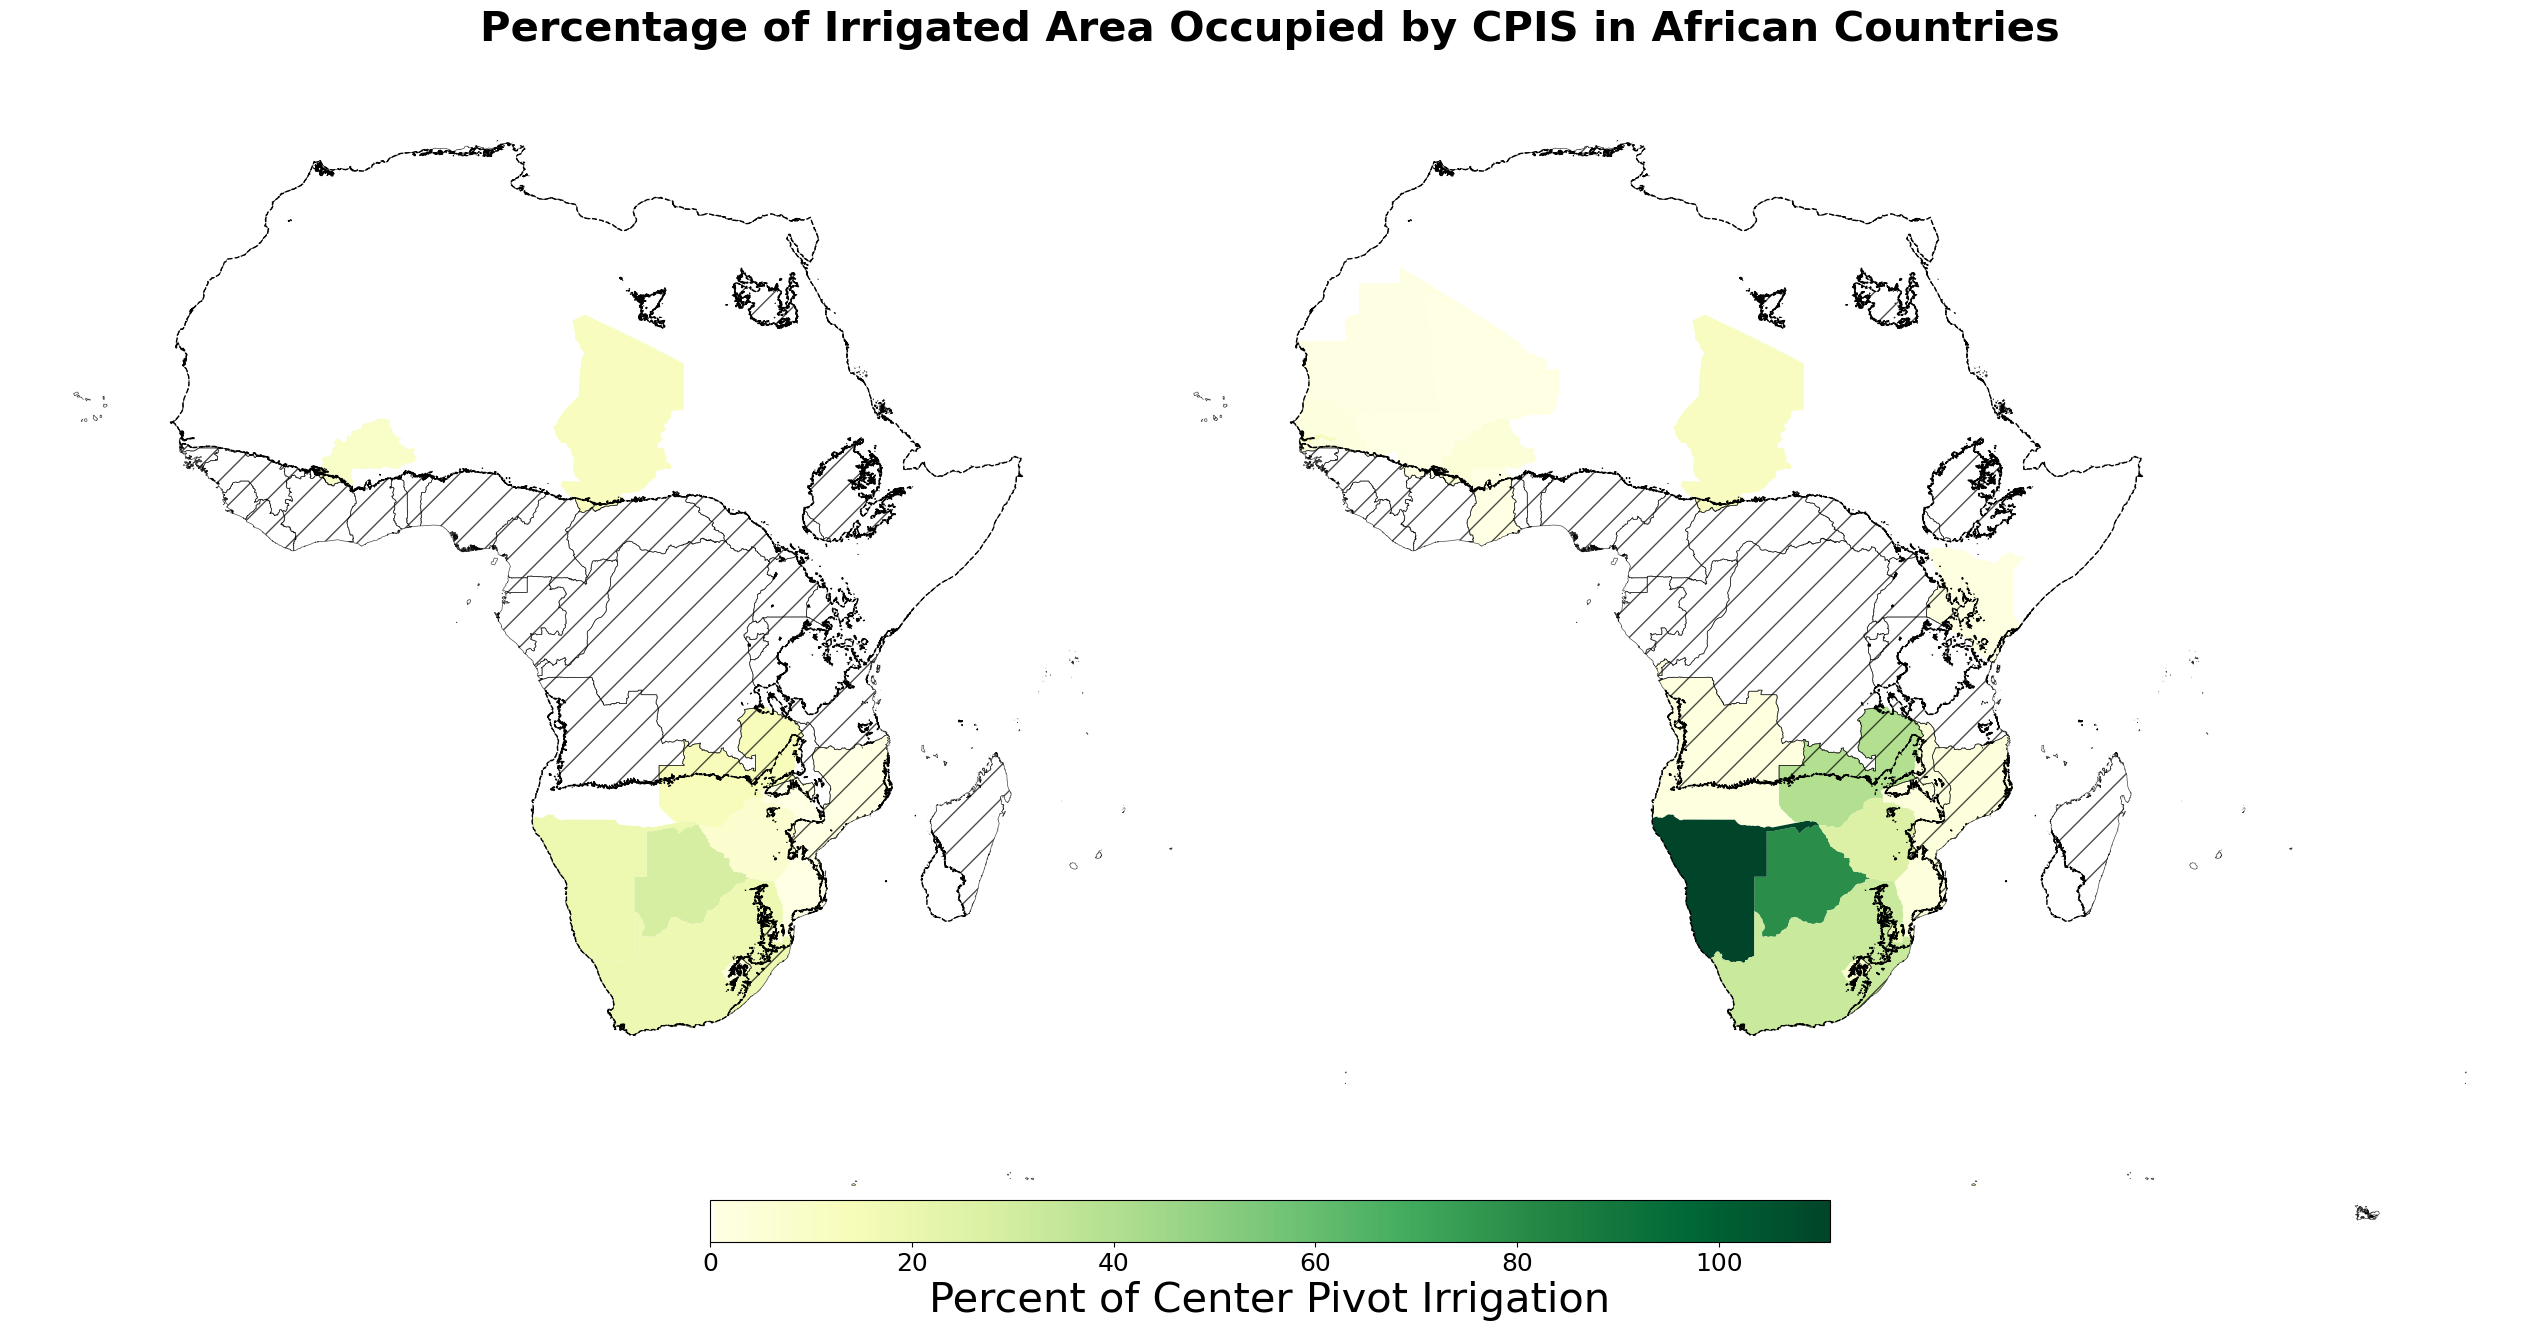

In [10]:
# Plotting
viridis = plt.colormaps.get_cmap('YlGn')
newcolors = viridis(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[0, :] = white  
custom_cmap = ListedColormap(newcolors)

simplification_tolerance = 0.01
arid_shapefile['geometry'] = arid_shapefile['geometry'].simplify(simplification_tolerance)
merged_geo_2000['geometry'] = merged_geo_2000['geometry'].simplify(simplification_tolerance)
merged_geo_2021['geometry'] = merged_geo_2021['geometry'].simplify(simplification_tolerance)

fig, ax = plt.subplots(1, 2, figsize=(28, 14), sharex=True, sharey=True)
plt.subplots_adjust(wspace=-0.2, hspace=0, left=0.05, right=0.95, top=0.95, bottom=0.05)

# Plot 2000 data
SSA_countries = merged_geo_2000[~merged_geo_2000['ISO'].isin(non_ssa_countries)]
non_SSA_countries = merged_geo_2000[merged_geo_2000['ISO'].isin(non_ssa_countries)]
# Only plot if there are non-SSA countries present and geometries are valid
if not non_SSA_countries.empty and non_SSA_countries.geometry.notnull().any():
    non_SSA_countries = non_SSA_countries[non_SSA_countries.is_valid]
    non_SSA_countries.plot(ax=ax[0], color='lightgray', edgecolor='black', hatch='/', zorder=1)
SSA_countries.plot(column='Percent_CPIS', ax=ax[0], legend=False, cmap=custom_cmap, vmin=0, vmax=max_value, zorder=2)
non_arid_regions = SSA_countries.overlay(arid_shapefile, how='difference')
if not non_arid_regions.empty and non_arid_regions.geometry.notnull().any():
    non_arid_regions = non_arid_regions[non_arid_regions.is_valid]
    non_arid_regions.plot(ax=ax[0], facecolor="none", edgecolor='black', hatch='/', linewidth=0.5, alpha=0.7, zorder=3)
arid_shapefile.boundary.plot(ax=ax[0], edgecolor='black', linewidth=1, linestyle='--', zorder=4)
ax[0].set_axis_off()                 

# Plot 2021 data
SSA_countries_2021 = merged_geo_2021[~merged_geo_2021['ISO'].isin(non_ssa_countries)]
non_SSA_countries_2021 = merged_geo_2021[merged_geo_2021['ISO'].isin(non_ssa_countries)]
if not non_SSA_countries_2021.empty and non_SSA_countries_2021.geometry.notnull().any():
    non_SSA_countries_2021 = non_SSA_countries_2021[non_SSA_countries_2021.is_valid]
    non_SSA_countries_2021.plot(ax=ax[1], color='lightgray', edgecolor='black', hatch='/', zorder=1)
SSA_countries_2021.plot(column='Percent_CPIS', ax=ax[1], legend=False, cmap=custom_cmap, vmin=0, vmax=max_value, zorder=2)
non_arid_regions_2021 = SSA_countries_2021.overlay(arid_shapefile, how='difference')
if not non_arid_regions_2021.empty and non_arid_regions_2021.geometry.notnull().any():
    non_arid_regions_2021 = non_arid_regions_2021[non_arid_regions_2021.is_valid]
    non_arid_regions_2021.plot(ax=ax[1], facecolor="none", edgecolor='black', hatch='/', linewidth=0.5, alpha=0.7, zorder=3)
arid_shapefile.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1, linestyle='--', zorder=4)
ax[1].set_axis_off()

# Add main title and colorbar
fig.suptitle("Percentage of Irrigated Area Occupied by CPIS in African Countries", fontsize=30, fontweight='bold')
cbar_ax = fig.add_axes([0.3, 0.1, 0.4, 0.03]) 
sm = plt.cm.ScalarMappable(cmap=custom_cmap, norm=Normalize(vmin=0, vmax=max_value))
sm._A = []
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Percent of Center Pivot Irrigation", fontsize=30)
cbar.ax.tick_params(labelsize=18)
plt.show()